## Agenda

This notebook is meant to select and fit the model.<br>

The target variable is the 'bike_differential', an integer equal to:<br>
[trips ending at a given station (positive) **MINUS** trips ending at the station (negative)]<br>

There will be a separate model fitted for **each station**, as stations behave very differently from each other and there are thousands of observations for each station in the data.<br>

We have already observed the relationship between time of day and bike activity when setting the time buckets.<br>
However, we do need to explore the relationship between weather (current and normal) and bike activity to determine which weather variables are significant.<br>

After the feature variables have been selected, we will start with a decision tree before moving to linear regression.<br>
Root mean squared error (RMSE) will serve as the evaluation metric, with average bike_differential for the station across all time buckets serving as the null model.

In [1]:
# Start out by importing basic software packages.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Import observation data, as prepared in the 'Data Preparation.ipynb' notebook.

columns = [
    'tag',
    'station',
    'date',
    'time',
    'start_tag_count',
    'end_tag_count',
    'bike_differential',
    'normal_temp_range',
    'normal_temp_ave',
    'normal_temp_max',
    'normal_temp_min',
    'current_temp',
    'current_dew_point',
    'current_humidity',
    'current_wind_speed',
    'current_pressure',
    'current_precipitation',
    'total_activity'
]

data_types = {
    'tag':object,
    'station':np.int64,
    'date':object,
    'time':np.int64,
    'start_tag_count':np.int64,
    'end_tag_count':np.int64,
    'bike_differential':np.int64,
    'normal_temp_range':np.float64,
    'normal_temp_ave':np.float64,
    'normal_temp_max':np.float64,
    'normal_temp_min':np.float64,
    'current_temp':np.float64,
    'current_dew_point':np.float64,
    'current_humidity':np.float64,
    'current_wind_speed':np.float64,
    'current_pressure':np.float64,
    'current_precipitation':np.float64,
    'total_activity':np.int64
}

divvy = pd.read_csv('./Supporting_Workfiles/divvy_data.csv',
                            header=0, names=columns, index_col='tag', dtype=data_types,
                            parse_dates=['date'], infer_datetime_format=True)

# Some slight re-ordering of the columns.

divvy = divvy[[
    'station',
    'date',
    'time',
    'start_tag_count',
    'end_tag_count',
    'bike_differential',
    'total_activity',
    'normal_temp_range',
    'normal_temp_ave',
    'normal_temp_max',
    'normal_temp_min',
    'current_temp',
    'current_dew_point',
    'current_humidity',
    'current_wind_speed',
    'current_pressure',
    'current_precipitation'
]]

In [3]:
# We will also import information about the stations themselves.

columns = [
    'id',
    'name',
    'city',
    'latitude',
    'longitude',
    'dpcapacity',
    'online_date',
    'start_count',
    'end_count',
    'start_min',
    'end_min',
    'start_max',
    'end_max',
    'first_day_operational'
]

data_types = {
    'id':np.int64,
    'name':object,
    'city':object,
    'latitude':np.float64,
    'longitude':np.float64,
    'dpcapacity':np.int64,
    'online_date':object,
    'start_count':np.int64,
    'end_count':np.int64,
    'start_min':object,
    'end_min':object,
    'start_max':object,
    'end_max':object,
    'first_day_operational':object
}

stations = pd.read_csv('./Supporting_Workfiles/final_station_data.csv',
                            header=0, names=columns, index_col='id', dtype=data_types,
                            parse_dates=['online_date','start_min','end_min','start_max','end_max','first_day_operational'],
                            infer_datetime_format=True)

### Evaluate Weather Variables

In [38]:
# To evaluate weather, we start by adding tags for date and time.
divvy.loc[:,'day_of_year'] = divvy.loc[:,'date'].dt.month.astype(str) + '-' + divvy.loc[:,'date'].dt.day.astype(str)
divvy.loc[:,'date_and_time'] = divvy.loc[:,'date'].dt.date.astype(str) + 'Time' + divvy.loc[:,'time'].astype(str)

# Next, we create dataframes with the sums.
rides_by_day = divvy.groupby('day_of_year')['start_tag_count'].sum().to_frame('total_rides')
rides_by_date_and_time = divvy.groupby('date_and_time')['start_tag_count'].sum().to_frame('total_rides')

# We can now drop the tag columns.
divvy = divvy.drop(['day_of_year','date_and_time'], axis=1)

In [39]:
# Next, we load in weather data and merge it into the new dataframes.

columns = [
    'day_of_year',
    'normal_temp_range',
    'normal_temp_ave',
    'normal_temp_max',
    'normal_temp_min'
]

data_types = {
    'day_of_year':object,
    'normal_temp_range':np.float64,
    'normal_temp_ave':np.float64,
    'normal_temp_max':np.float64,
    'normal_temp_min':np.float64
}

daily_weather_normals = pd.read_csv('./Supporting_Workfiles/Daily_Weather_Normals.csv',
                            header=0, names=columns, index_col='day_of_year', dtype=data_types)

rides_by_day = rides_by_day.merge(daily_weather_normals, how='left', left_index=True, right_index=True)

In [40]:
columns = [
    'date_and_time',
    'current_temp',
    'current_dew_point',
    'current_humidity',
    'current_wind_speed',
    'current_pressure',
    'current_precipitation'
]

data_types = {
    'date_and_time':object,
    'current_temp':np.float64,
    'current_dew_point':np.float64,
    'current_humidity':np.float64,
    'current_wind_speed':np.float64,
    'current_pressure':np.float64,
    'current_precipitation':np.float64
}

current_weather_data = pd.read_csv('./Supporting_Workfiles/Hourly_Weather_Data.csv',
                            header=0, names=columns, index_col='date_and_time', dtype=data_types)

rides_by_date_and_time = rides_by_date_and_time.merge(current_weather_data, how='left', left_index=True, right_index=True)

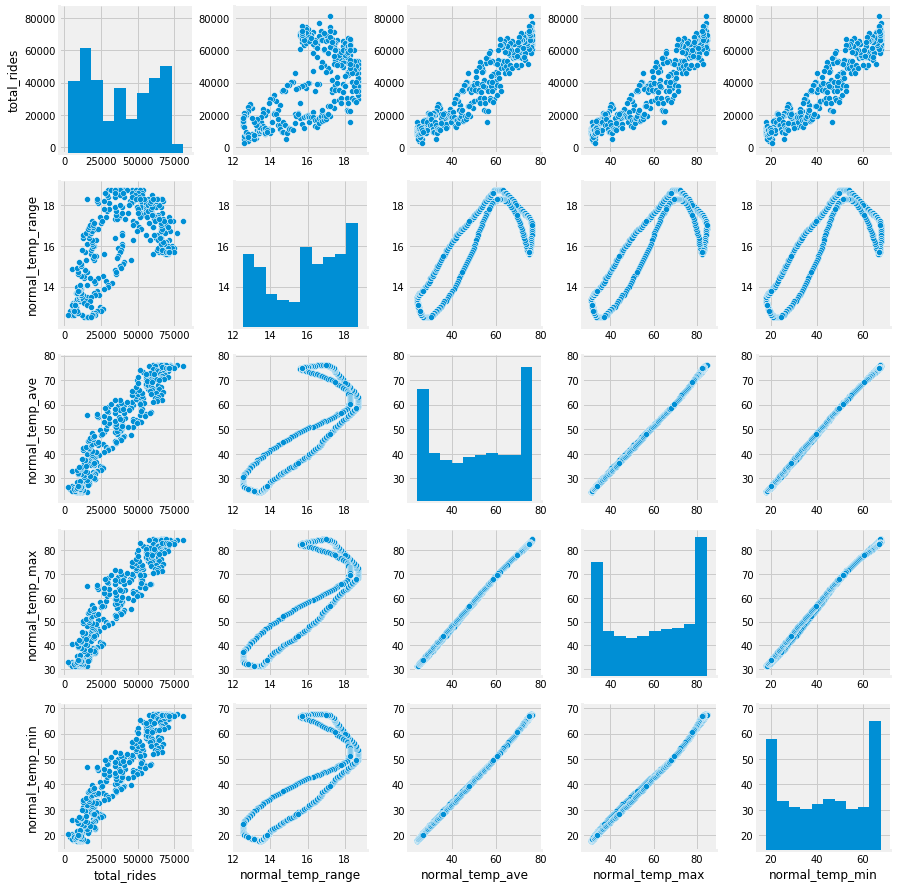

In [45]:
# Let's check how the daily weather normals correlate with each other and with bike activity.
sns.pairplot(rides_by_day);

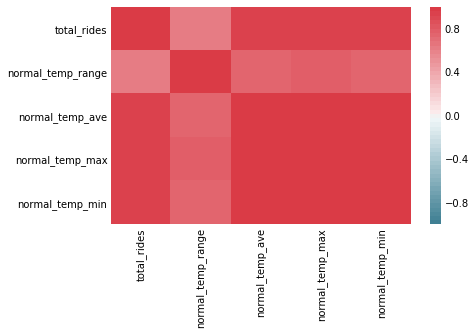

In [57]:
sns.heatmap(rides_by_day.corr(), vmin=-1, vmax=1, 
            cmap=sns.diverging_palette(220, 10, n=51));

In [48]:
rides_by_day.corr()

,total_rides,normal_temp_range,normal_temp_ave,normal_temp_max,normal_temp_min
total_rides,1.000000,0.643684,0.949477,0.944921,0.953175
normal_temp_range,0.643684,1.000000,0.759075,0.780672,0.734455
normal_temp_ave,0.949477,0.759075,1.000000,0.999425,0.999311
normal_temp_max,0.944921,0.780672,0.999425,1.000000,0.997486
normal_temp_min,0.953175,0.734455,0.999311,0.997486,1.000000


As we can see above, the temp_ave, temp_min, and temp_max are all very closely correlated.
It would only make sense to include one of these variables.

The variable most closely correlated with the total_rides is temp_min, so we will take that for the analysis.

The temp_range is the least closely associated with total_rides and has higher correlation with the temp_min, so we will leave it out.

Feature variable added: **normal_temp_min**

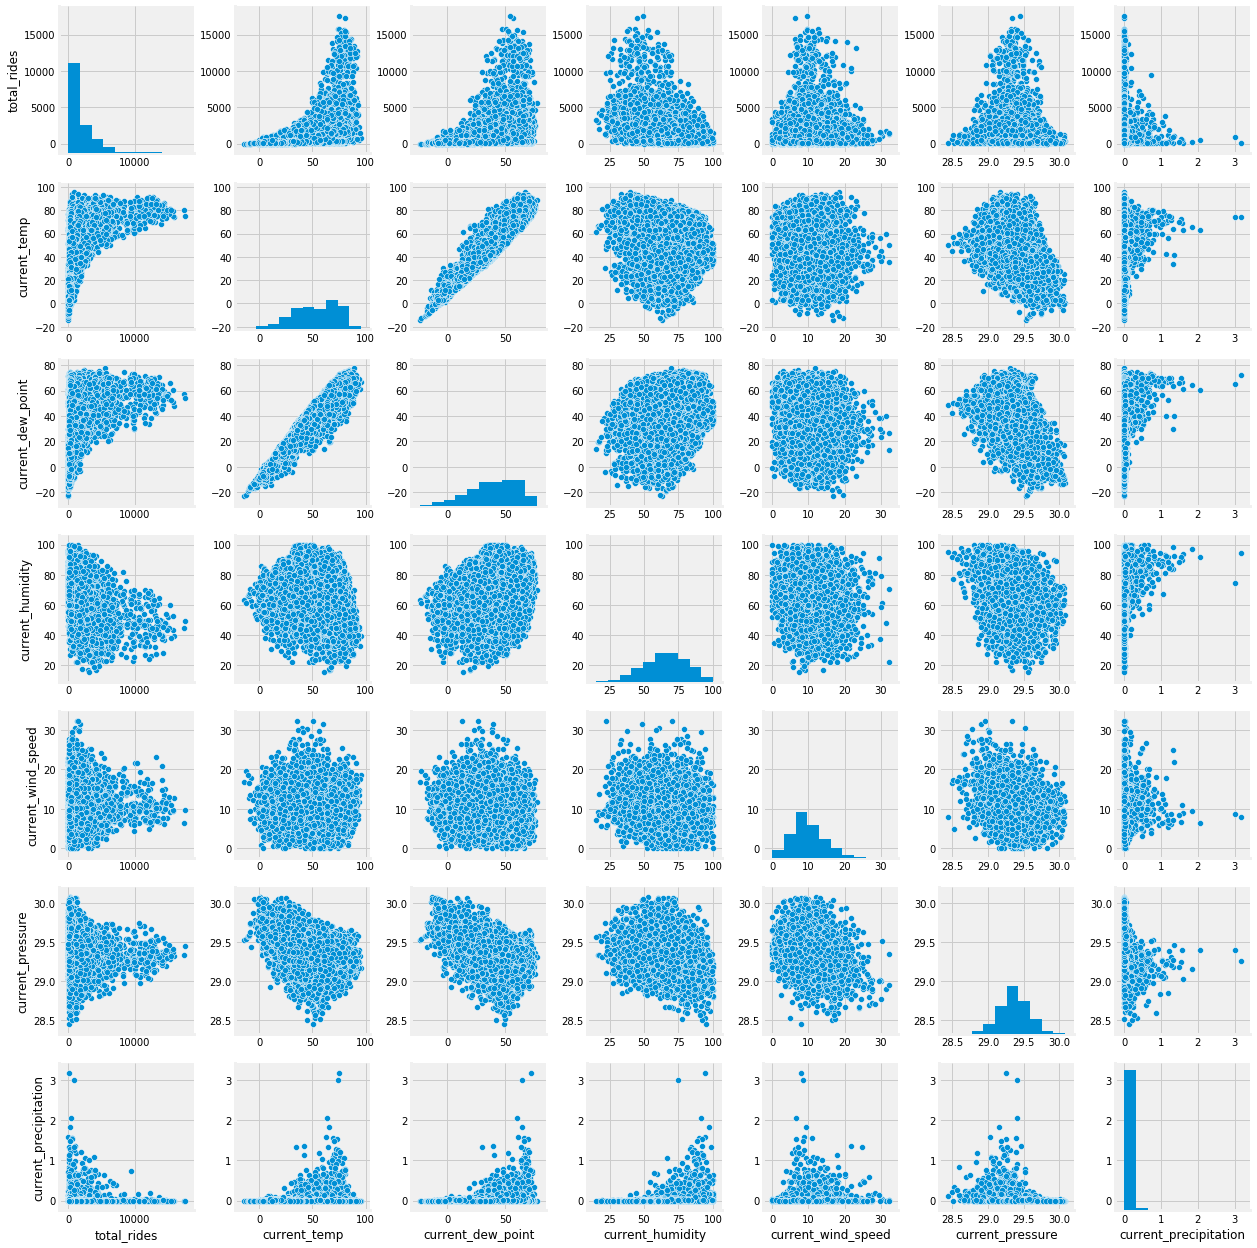

In [46]:
# Let's check how the daily weather normals correlate with each other and with bike activity.
sns.pairplot(rides_by_date_and_time);

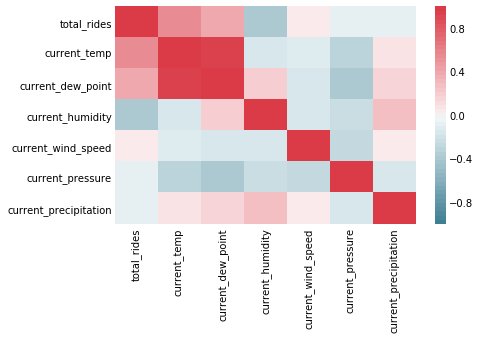

In [58]:
sns.heatmap(rides_by_date_and_time.corr(), vmin=-1, vmax=1, 
            cmap=sns.diverging_palette(220, 10, n=51));

In [56]:
rides_by_date_and_time.corr()

,total_rides,current_temp,current_dew_point,current_humidity,current_wind_speed,current_pressure,current_precipitation
total_rides,1.000000,0.532708,0.390112,-0.397224,0.055018,-0.073875,-0.063931
current_temp,0.532708,1.000000,0.941542,-0.154007,-0.119430,-0.333144,0.063757
current_dew_point,0.390112,0.941542,1.000000,0.182063,-0.172857,-0.400867,0.142523
current_humidity,-0.397224,-0.154007,0.182063,1.000000,-0.155386,-0.232962,0.257775
current_wind_speed,0.055018,-0.119430,-0.172857,-0.155386,1.000000,-0.259796,0.053768
current_pressure,-0.073875,-0.333144,-0.400867,-0.232962,-0.259796,1.000000,-0.161939
current_precipitation,-0.063931,0.063757,0.142523,0.257775,0.053768,-0.161939,1.000000


The three variables significantly associated with the total_rides are temp, dew_point, and humidity.<br>
However, the temp and dew_point are very, very closely correlated, so we will not use dew_point.<br>

Feature variables added: **current_temp, current_humidity**

### Evaluate Null Model

The null model will be slightly more complicated than standard.<br>
We will set the null prediction to be the average bike_differential for the given **station and time_bucket**.
It would be unfair to take the average across all time buckets for each station, as they are so different, both in number of hours included and general use pattern.

In [4]:
# First we calculate the mean bike_differential for every station/time combination.
temp_list = []
for station in stations.index:
    for time in range(8):
        row_filter = (divvy.loc[:,'station'] == station) & (divvy.loc[:,'time'] == time)
        tag = 'Station'+str(station)+'Time'+str(time)
        null_pred = divvy.loc[row_filter, 'bike_differential'].mean()
        temp_list.append((tag, null_pred))

In [5]:
# We create a dataframe out of the null predictions.
column_list = ['null_tag', 'null_pred']
null_pred_list = pd.DataFrame(temp_list, columns=column_list)
null_pred_list = null_pred_list.set_index('null_tag', drop=True, verify_integrity=True)

In [6]:
# We create a temporary tag and merge the null predictions into the main dataset.
divvy.loc[:,'temp_tag'] = 'Station'+divvy.loc[:,'station'].astype(str)+'Time'+divvy.loc[:,'time'].astype(str)
divvy = divvy.merge(null_pred_list, how='left', left_on='temp_tag', right_index=True)
divvy = divvy.drop('temp_tag', axis=1)

In [7]:
# Now we can use the null_pred to calculate the null RMSE for each station.
from sklearn.metrics import mean_squared_error
temp_list = []
for station in stations.index:
    row_filter = divvy.loc[:,'station'] == station
    y = divvy.loc[row_filter,'bike_differential']
    y_pred = divvy.loc[row_filter,'null_pred']
    null_rmse = np.sqrt(mean_squared_error(y, y_pred))
    temp_list.append((station, null_rmse))
    
model_results = pd.DataFrame(temp_list, columns=['station', 'null_rmse'])
model_results = model_results.set_index('station', drop=True, verify_integrity=True)

In [8]:
model_results.describe()

,null_rmse
count,565.000000
mean,2.492552
std,2.561555
min,0.046822
25%,0.793228
50%,1.975058
75%,3.222389
max,22.053789


We see here that the null model actually isn't too bad. By simply looking at average bike_differential for each station and time_bucket, we get an average RMSE of 2.5 across all stations. However, some stations do much more poorly, with a max RMSE of 22.

### Evaluate Linear Models

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [38]:
scaler = StandardScaler()
poly = PolynomialFeatures(4)
lr = LinearRegression()
kf = KFold(5, shuffle=True)
temp_list = []
for station in stations.index:
    station_filter = (divvy.loc[:,'station'] == station)
    num_feature_cols = ['normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[station_filter, num_feature_cols]
    X = scaler.fit_transform(X)
    X = poly.fit_transform(X)
    time_values = divvy.loc[station_filter, 'time']
    time_values = pd.get_dummies(time_values, drop_first=True)
    X = np.append(X, values=time_values, axis=1)
    y = divvy.loc[station_filter, 'bike_differential']
    lr_RMSE = np.mean(np.sqrt(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
    temp_list.append((station, lr_RMSE))

column_list = ['station', 'lr_RMSE']
lr_results = pd.DataFrame(temp_list, columns=column_list)
lr_results = lr_results.set_index('station', drop=True, verify_integrity=True)

In [43]:
lr_results.describe()

,lr_RMSE
count,565.000000
mean,2.482930
std,2.512858
min,0.034062
25%,0.798839
50%,1.979332
75%,3.224762
max,20.769727


These results, when compared to the null, are not very encouraging. There is very little improvement in the predictions.

In [42]:
lr = LinearRegression()
kf = KFold(5, shuffle=True)
temp_list = []
for station in stations.index:
    station_filter = (divvy.loc[:,'station'] == station)
    num_feature_cols = ['normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[station_filter, num_feature_cols]
    time_values = divvy.loc[station_filter, 'time']
    time_values = pd.get_dummies(time_values, drop_first=True)
    X = np.append(X, values=time_values, axis=1)
    y = divvy.loc[station_filter, 'bike_differential']
    lr_RMSE = np.mean(np.sqrt(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
    temp_list.append((station, lr_RMSE))

column_list = ['station', 'lr_RMSE_2']
lr_results_2 = pd.DataFrame(temp_list, columns=column_list)
lr_results_2 = lr_results_2.set_index('station', drop=True, verify_integrity=True)

In [44]:
lr_results_2.describe()

,lr_RMSE_2
count,565.000000
mean,2.482950
std,2.533575
min,0.042465
25%,0.794816
50%,1.977183
75%,3.230419
max,21.265235


These results seem to at least confirm, given the similarity to the first linear regression results, that our code was OK. A strictly linear model just doesn't perform very well here.

### Evaluate Decsision Tree-Based Models

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
rfreg = RandomForestRegressor(n_estimators=150, min_samples_split=0.05, bootstrap=True, oob_score=False)
kf = KFold(5, shuffle=True)
temp_list = []
for station in stations.index:
    station_filter = (divvy.loc[:,'station'] == station)
    feature_cols = ['time', 'normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[station_filter, feature_cols]
    y = divvy.loc[station_filter, 'bike_differential']
    rfreg.fit(X, y)
    rfreg_RMSE = np.mean(np.sqrt(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
    time_import = rfreg.feature_importances_[0]
    normal_temp_min_import = rfreg.feature_importances_[1]
    current_temp_import = rfreg.feature_importances_[2]
    current_humidity_import = rfreg.feature_importances_[3]
    temp_list.append((station, rfreg_RMSE, time_import, normal_temp_min_import, current_temp_import, current_humidity_import))

column_list = [
    'station',
    'rfreg_RMSE',
    'time_import',
    'normal_temp_min_import',
    'current_temp_import',
    'current_humidity_import'
]
rfreg_results = pd.DataFrame(temp_list, columns=column_list)
rfreg_results = rfreg_results.set_index('station', drop=True, verify_integrity=True)

In [50]:
rfreg_results.describe()

,rfreg_RMSE,time_import,normal_temp_min_import,current_temp_import,current_humidity_import
count,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2.347739,0.566878,0.122977,0.203696,0.106450
std,2.287885,0.285053,0.086829,0.123799,0.110043
min,0.041399,0.003495,0.001742,0.008801,0.001624
25%,0.793765,0.336558,0.047305,0.108356,0.021708
50%,1.907099,0.675379,0.105006,0.168570,0.057692
75%,3.063866,0.805773,0.189191,0.298182,0.173237
max,20.508510,0.956000,0.413763,0.605185,0.589919


In [51]:
rfreg = RandomForestRegressor(n_estimators=150, max_depth=5, bootstrap=True, oob_score=False)
kf = KFold(5, shuffle=True)
temp_list = []
for station in stations.index:
    station_filter = (divvy.loc[:,'station'] == station)
    feature_cols = ['time', 'normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[station_filter, feature_cols]
    y = divvy.loc[station_filter, 'bike_differential']
    rfreg.fit(X, y)
    rfreg_RMSE = np.mean(np.sqrt(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
    time_import = rfreg.feature_importances_[0]
    normal_temp_min_import = rfreg.feature_importances_[1]
    current_temp_import = rfreg.feature_importances_[2]
    current_humidity_import = rfreg.feature_importances_[3]
    temp_list.append((station, rfreg_RMSE, time_import, normal_temp_min_import, current_temp_import, current_humidity_import))

column_list = [
    'station',
    'rfreg_RMSE_2',
    'time_import_2',
    'normal_temp_min_import_2',
    'current_temp_import_2',
    'current_humidity_import_2'
]
rfreg_results_2 = pd.DataFrame(temp_list, columns=column_list)
rfreg_results_2 = rfreg_results_2.set_index('station', drop=True, verify_integrity=True)

In [52]:
rfreg_results_2.describe()

,rfreg_RMSE_2,time_import_2,normal_temp_min_import_2,current_temp_import_2,current_humidity_import_2
count,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2.326152,0.551562,0.124594,0.198573,0.125247
std,2.207106,0.280412,0.081067,0.108465,0.121722
min,0.051840,0.033710,0.002535,0.014065,0.005821
25%,0.797065,0.301587,0.052186,0.113214,0.026322
50%,1.908761,0.652454,0.116131,0.174962,0.065714
75%,3.046848,0.792730,0.192281,0.287574,0.208930
max,16.351499,0.946122,0.398680,0.555544,0.515975


In [53]:
rfreg = RandomForestRegressor(n_estimators=150, max_depth=6, bootstrap=True, oob_score=False)
kf = KFold(5, shuffle=True)
temp_list = []
for station in stations.index:
    station_filter = (divvy.loc[:,'station'] == station)
    feature_cols = ['time', 'normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[station_filter, feature_cols]
    y = divvy.loc[station_filter, 'bike_differential']
    rfreg.fit(X, y)
    rfreg_RMSE = np.mean(np.sqrt(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
    time_import = rfreg.feature_importances_[0]
    normal_temp_min_import = rfreg.feature_importances_[1]
    current_temp_import = rfreg.feature_importances_[2]
    current_humidity_import = rfreg.feature_importances_[3]
    temp_list.append((station, rfreg_RMSE, time_import, normal_temp_min_import, current_temp_import, current_humidity_import))

column_list = [
    'station',
    'rfreg_RMSE_3',
    'time_import_3',
    'normal_temp_min_import_3',
    'current_temp_import_3',
    'current_humidity_import_3'
]
rfreg_results_3 = pd.DataFrame(temp_list, columns=column_list)
rfreg_results_3 = rfreg_results_3.set_index('station', drop=True, verify_integrity=True)

In [54]:
rfreg_results_3.describe()

,rfreg_RMSE_3,time_import_3,normal_temp_min_import_3,current_temp_import_3,current_humidity_import_3
count,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2.323652,0.501323,0.141489,0.209655,0.147509
std,2.196599,0.274201,0.080264,0.100286,0.118051
min,0.052427,0.031934,0.006683,0.019457,0.009220
25%,0.793029,0.235527,0.066412,0.129047,0.044249
50%,1.914373,0.567222,0.138436,0.197634,0.104692
75%,3.055300,0.749725,0.210720,0.296714,0.240555
max,16.165930,0.935718,0.406536,0.525708,0.520850


In [55]:
rfreg = RandomForestRegressor(n_estimators=150, max_depth=8, bootstrap=True, oob_score=False)
kf = KFold(5, shuffle=True)
temp_list = []
for station in stations.index:
    station_filter = (divvy.loc[:,'station'] == station)
    feature_cols = ['time', 'normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[station_filter, feature_cols]
    y = divvy.loc[station_filter, 'bike_differential']
    rfreg.fit(X, y)
    rfreg_RMSE = np.mean(np.sqrt(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
    time_import = rfreg.feature_importances_[0]
    normal_temp_min_import = rfreg.feature_importances_[1]
    current_temp_import = rfreg.feature_importances_[2]
    current_humidity_import = rfreg.feature_importances_[3]
    temp_list.append((station, rfreg_RMSE, time_import, normal_temp_min_import, current_temp_import, current_humidity_import))

column_list = [
    'station',
    'rfreg_RMSE_4',
    'time_import_4',
    'normal_temp_min_import_4',
    'current_temp_import_4',
    'current_humidity_import_4'
]
rfreg_results_4 = pd.DataFrame(temp_list, columns=column_list)
rfreg_results_4 = rfreg_results_4.set_index('station', drop=True, verify_integrity=True)

In [56]:
rfreg_results_4.describe()

,rfreg_RMSE_4,time_import_4,normal_temp_min_import_4,current_temp_import_4,current_humidity_import_4
count,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2.335409,0.417622,0.169124,0.229198,0.184056
std,2.201926,0.255551,0.075378,0.088277,0.109504
min,0.054031,0.046028,0.019414,0.026794,0.019938
25%,0.801756,0.155743,0.100579,0.158044,0.080743
50%,1.911849,0.417871,0.180568,0.234915,0.168475
75%,3.069363,0.652191,0.233907,0.301937,0.281660
max,16.324823,0.910852,0.431899,0.479940,0.464055


Based on this analysis, a random forest limited by max_depth, with a max_depth of 6, appears to be the most successful method. Note that we did not test all max_depths around 6, as the computing time for each round is very long, and the difference is not great.

In [ ]:
# DO NOT RUN, TAKES TOO LONG.
kf = KFold(5, shuffle=True)
temp_list = []
for n in range(1,21):
    rfreg = RandomForestRegressor(n_estimators=150, max_depth=n, bootstrap=True, oob_score=False)
    feature_cols = ['station', 'time', 'normal_temp_min', 'current_temp', 'current_humidity']
    X = divvy.loc[:, feature_cols]
    y = divvy.loc[:, 'bike_differential']
    rfreg.fit(X, y)
    rfreg_RMSE = np.mean(np.sqrt(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
    station_import = rfreg.feature_importances_[0]
    time_import = rfreg.feature_importances_[1]
    normal_temp_min_import = rfreg.feature_importances_[2]
    current_temp_import = rfreg.feature_importances_[3]
    current_humidity_import = rfreg.feature_importances_[4]
    temp_list.append((n, rfreg_RMSE, station_import, time_import, normal_temp_min_import, current_temp_import, current_humidity_import))

column_list = [
    'max_depth',
    'rfreg_RMSE',
    'station_import',
    'time_import',
    'normal_temp_min_import',
    'current_temp_import',
    'current_humidity_import'
]
combined_rfreg_results = pd.DataFrame(temp_list, columns=column_list)

### Combine results and export to CSV

In [65]:
model_results = model_results.merge(lr_results, how='left', left_index=True, right_index=True)
model_results = model_results.merge(lr_results_2, how='left', left_index=True, right_index=True)
model_results = model_results.merge(rfreg_results, how='left', left_index=True, right_index=True)
model_results = model_results.merge(rfreg_results_2, how='left', left_index=True, right_index=True)
model_results = model_results.merge(rfreg_results_3, how='left', left_index=True, right_index=True)
model_results = model_results.merge(rfreg_results_4, how='left', left_index=True, right_index=True)

In [73]:
model_results = stations.merge(model_results, how='left', left_index=True, right_index=True)

In [78]:
model_results.to_csv('./Supporting_Workfiles/model_results.csv')